In [3]:
import os
import mat73
import matplotlib.pyplot as plt
import numpy as np
path = './'
fname = os.path.join(path, 'Dataset2.mat')

from scipy.io import loadmat
DATA = mat73.loadmat(fname)

In [5]:
DATA.keys()

dict_keys(['monkeyL', 'monkeyN'])

In [6]:
%whos

Variable   Type        Data/Info
--------------------------------
DATA       dict        n=2
fname      str         ./Dataset2.mat
loadmat    function    <function loadmat at 0x111603e60>
mat73      module      <module 'mat73' from '/Us<...>kages/mat73/__init__.py'>
os         module      <module 'os' from '/Users<...>da3/lib/python3.7/os.py'>
path       str         ./


In [10]:
DATA['monkeyL'].keys()

dict_keys(['MT', 'PT', 'RT', 'force', 'grip', 'neuron', 'spikes'])

In [178]:
nTime, nNeuron, nTrial = DATA['monkeyL']['spikes'].shape
spikes = DATA['monkeyL']['spikes']
neurons = DATA['monkeyL']['neuron']
grips = DATA['monkeyL']['grip']
forces = DATA['monkeyL']['force']

# without smoothing

In [133]:
# for j in range(134):
#     s = 0
#     for i in range(20):
#         s = s + spikes[i][0][j]
#     print(s)

In [75]:
# Use 20-ms non-overlapping windows to bin the spikes.
bin_spikes = spikes.reshape(int(5500/20), 20, 93, 134)
bin_spikes = bin_spikes.sum(axis = 1)

In [77]:
bin_spikes.shape

(275, 93, 134)

In [165]:
grips

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [166]:
(grips == 1).sum()

70

In [124]:
SG_bin_spikes = bin_spikes[:,:,:70]
PG_bin_spikes = bin_spikes[:,:,70:]

In [125]:
trail_averaged_spikes_pn_SG = np.mean(SG_bin_spikes, axis = 2)
trail_averaged_spikes_pn_PG = np.mean(PG_bin_spikes, axis = 2)

In [126]:
trail_averaged_spikes_pn_SG .shape

(275, 93)

In [131]:
trail_averaged_spikes_pn_PG[:,2].shape

(93,)

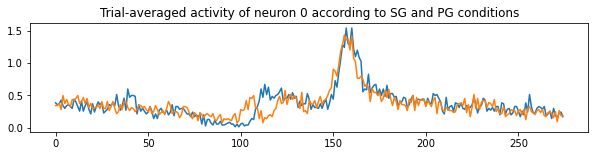

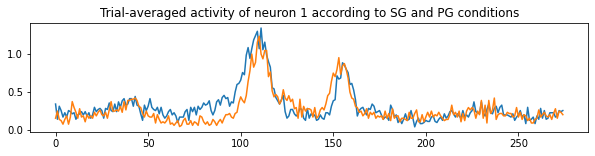

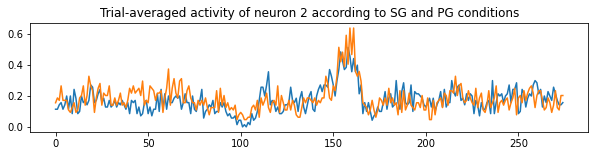

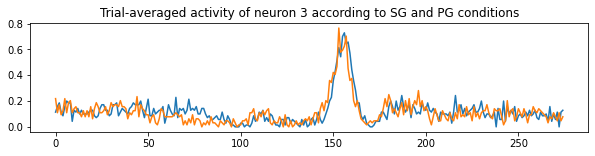

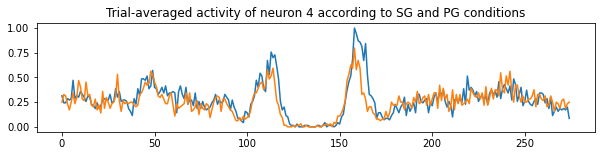

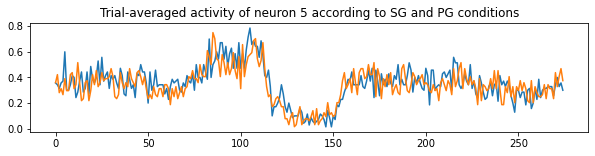

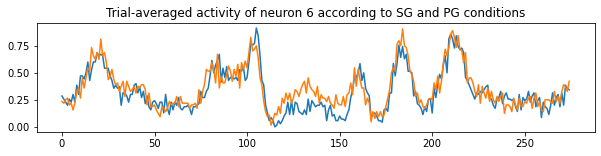

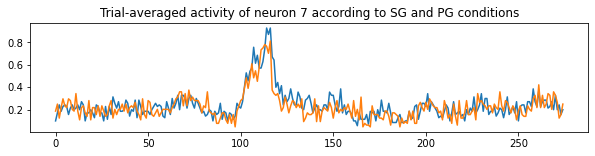

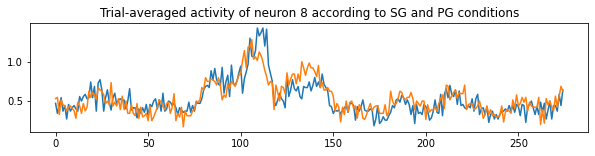

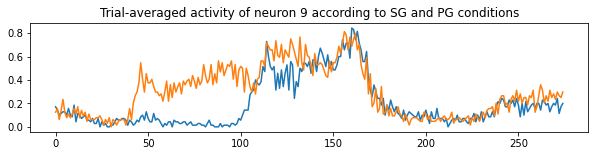

In [163]:
for i in range(10):
    plt.figure(figsize=(10,2))
    plt.plot(trail_averaged_spikes_pn_SG[:,i])
    plt.plot(trail_averaged_spikes_pn_PG[:,i])
    plt.title(f'Trial-averaged activity of neuron {i} according to SG and PG conditions')

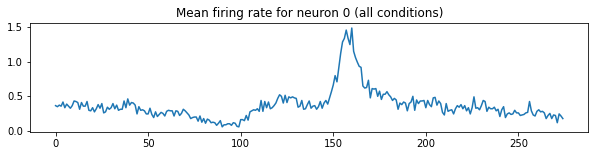

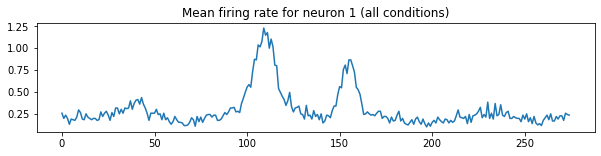

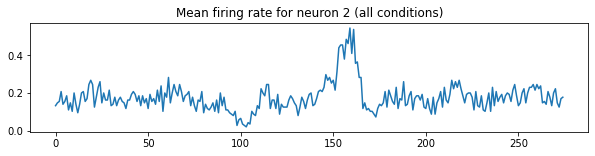

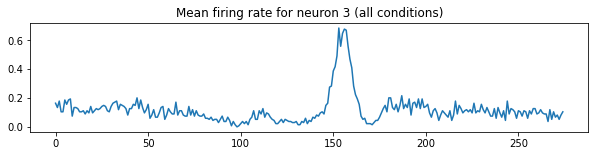

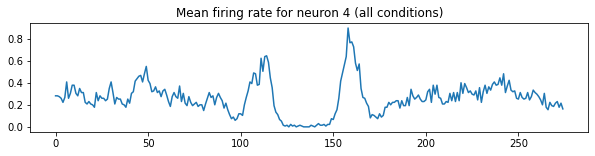

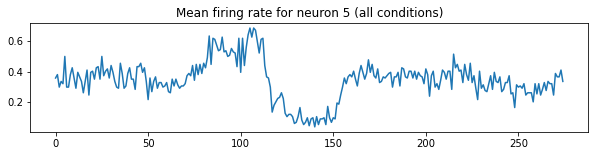

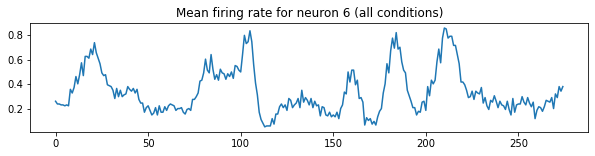

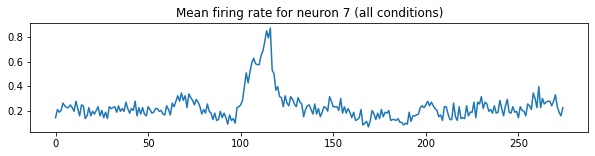

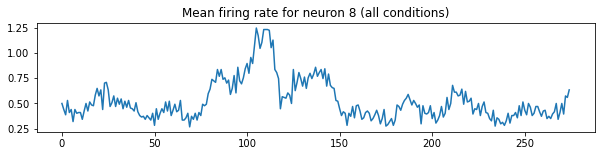

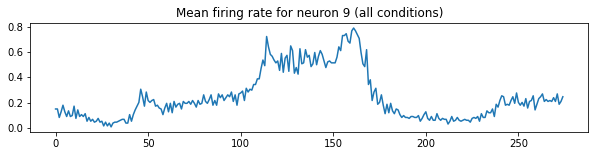

In [162]:
for i in range(10):
    plt.figure(figsize=(10,2))
    plt.plot(np.mean(bin_spikes[:,i,:], axis=1))
    plt.title(f'Mean firing rate for neuron {i} (all conditions)')

# Smoothing

In [192]:
def gaussian_filter1d(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

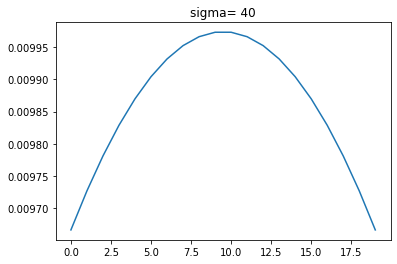

In [217]:
fig,ax = plt.subplots()
ax.plot(gaussian_filter1d(size=20,sigma=40))
ax.set_title(f'sigma= 40')
plt.show()

In [218]:
from scipy.ndimage import convolve1d
smoothed_bin_spikes = convolve1d(bin_spikes, gaussian_filter1d(size=20,sigma=40), axis=0)


In [158]:
fs = 50
t_stamps = np.arange(0,bin_spikes.shape[0]/fs, 1/fs)

In [169]:
states = ['CUE_ON', 'CUE_OFF', 'GO'] # cues
states_ind = [0.7,1,2] # time at which transition occurs (in seconds)

all_cond = ['PG/HF', 'PG/LF', 'SG/HF', 'SG/LF']
all_cond_ind = [(2,1), (2,2), (1,1), (1,2)]

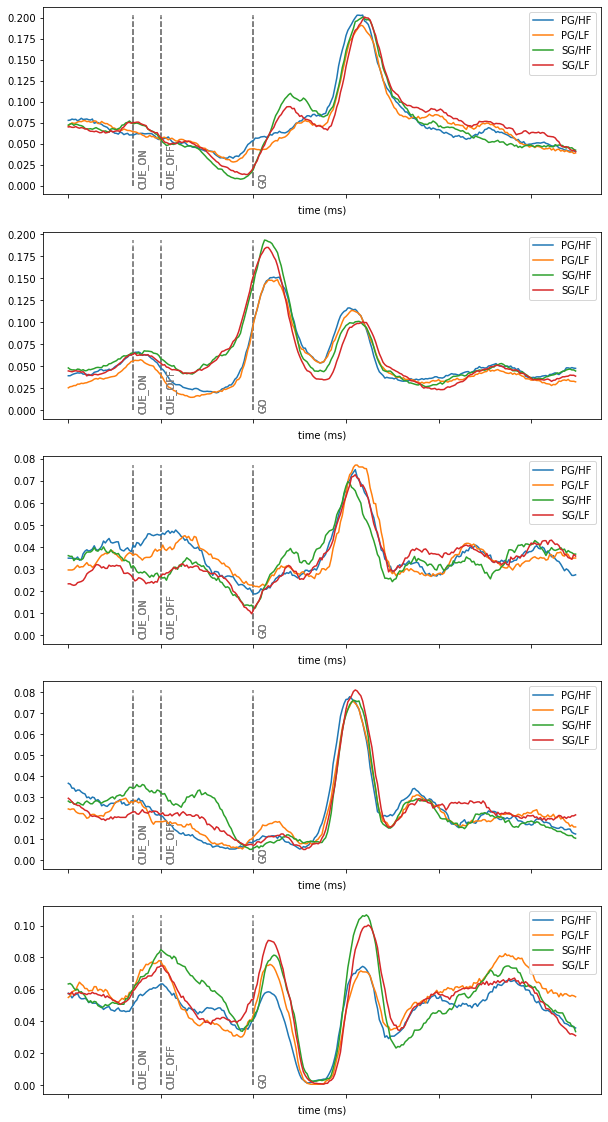

In [223]:
n_plot = 5 
fig, axes = plt.subplots(n_plot, 1, figsize=(10,4*n_plot))
for i in range(n_plot):   
    for (j, cond) in enumerate(all_cond):    
        grip_mask = all_cond_ind[j][0] 
        force_mask = all_cond_ind[j][1] 
        cond_trials_mask = (grips == grip_mask) & (forces == force_mask)
        trail_avg_smoothed_spikes_pn  = np.mean(smoothed_bin_spikes[:,i,cond_trials_mask], 1) 
        
        axes[i].plot(t_stamps, trail_avg_smoothed_spikes_pn, label=cond)
        axes[i].vlines(states_ind, ymin=0, ymax=np.max(trail_avg_smoothed_spikes_pn), linestyles='dashed', color='grey')
        axes[i].legend(loc='upper right')
        axes[i].set_xticklabels([])
        for k in range(len(states_ind)):
            axes[i].text(states_ind[k]+0.05, round(np.max(trail_avg_smoothed_spikes_pn)/1.5), states[k], rotation=90, color='grey')
        axes[i].set_xlabel('time (ms)')


In [183]:
smoothed_bin_spikes[:,0,(grips == 1) & (forces == 2)].shape

(275, 40)